## Imports, Device Setup & Image Preprocessing

Loads all required libraries and selects GPU/CPU automatically.
Defines a function to load, resize, normalize, and convert images into tensors.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def replace_relu_with_non_inplace(module):
    for name, layer in module.named_children():
        if isinstance(layer, nn.ReLU):
            setattr(module, name, nn.ReLU(inplace=False))
        else:
            replace_relu_with_non_inplace(layer)

def load_image(img_path, max_size=400):
    image = Image.open(img_path).convert("RGB")
    size = min(max(image.size), max_size)
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])
    return transform(image).unsqueeze(0).to(device)


## Load Images, Load VGG19 & Define Feature Extraction

Loads the content and style images and initializes the pretrained VGG19 model.
Also defines helper functions to extract VGG layer outputs and compute Gram matrices.

In [ ]:
content_img = load_image("/content/drive/MyDrive/new_images/image_2.png")
style_img   = load_image("/content/drive/MyDrive/new_images/style.avif")

vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
replace_relu_with_non_inplace(vgg)
vgg = vgg.to(device).eval()

layer_map = {
    "0":  "conv_1",
    "5":  "conv_2",
    "10": "conv_3",
    "19": "conv_4",
    "28": "conv_5",
}

def get_features(img, model):
    feats = {}
    x = img
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layer_map:
            feats[layer_map[name]] = x
    return feats

def gram_matrix(tensor):
    _, d, h, w = tensor.shape
    t = tensor.view(d, h * w)
    return torch.mm(t, t.t())


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 201MB/s]


## Extract Content Features & Style Gram Matrices

Runs both images through VGG19 and collects their content and style features.
Style features are converted into Gram matrices to capture texture patterns.

In [ ]:
with torch.no_grad():
    content_features = get_features(content_img, vgg)
    style_features   = get_features(style_img, vgg)
    style_grams = {k: gram_matrix(v) for k, v in style_features.items()}


## Optimization Setup & Training Loop

Initializes the target image and sets style/content weights.
Uses LBFGS optimizer to iteratively update the target image for 700 steps.

In [ ]:
target = content_img.clone().requires_grad_(True).to(device)

style_weights = {
    "conv_1": 1.0,
    "conv_2": 0.75,
    "conv_3": 0.2,
    "conv_4": 0.2,
    "conv_5": 0.2
}

content_weight = 1e4
style_weight   = 1e2

optimizer = optim.LBFGS([target])

for step in range(700):
    def closure():
        optimizer.zero_grad()
        target_features = get_features(target, vgg)

        content_loss = ((target_features["conv_4"] - content_features["conv_4"])**2).mean()

        style_loss = 0
        for layer, w in style_weights.items():
            target_gram = gram_matrix(target_features[layer])
            style_gram  = style_grams[layer]
            _, d, h, w_spatial = target_features[layer].shape
            layer_loss = w * ((target_gram - style_gram)**2).mean()
            style_loss += layer_loss / (d * h * w_spatial)

        total_loss = content_weight * content_loss + style_weight * style_loss
        total_loss.backward()
        return total_loss

    loss = optimizer.step(closure)

    if step % 50 == 0:
        print("Step:", step, "Loss:", loss.item())


/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


Step: 0 Loss: 1054826.875
Step: 50 Loss: 133869.203125
Step: 100 Loss: 132061.953125
Step: 150 Loss: 131518.046875
Step: 200 Loss: 131223.71875
Step: 250 Loss: 131027.921875
Step: 300 Loss: 130880.6875
Step: 350 Loss: 130766.46875
Step: 400 Loss: 130676.984375
Step: 450 Loss: 130602.296875
Step: 500 Loss: 130540.53125
Step: 550 Loss: 130486.078125
Step: 600 Loss: 130437.4375
Step: 650 Loss: 130393.9609375


## Convert to Image, Save Output & Display Results

Converts the optimized tensor back into a normal image and saves the result.
Finally displays the content, style, and stylized output side-by-side.

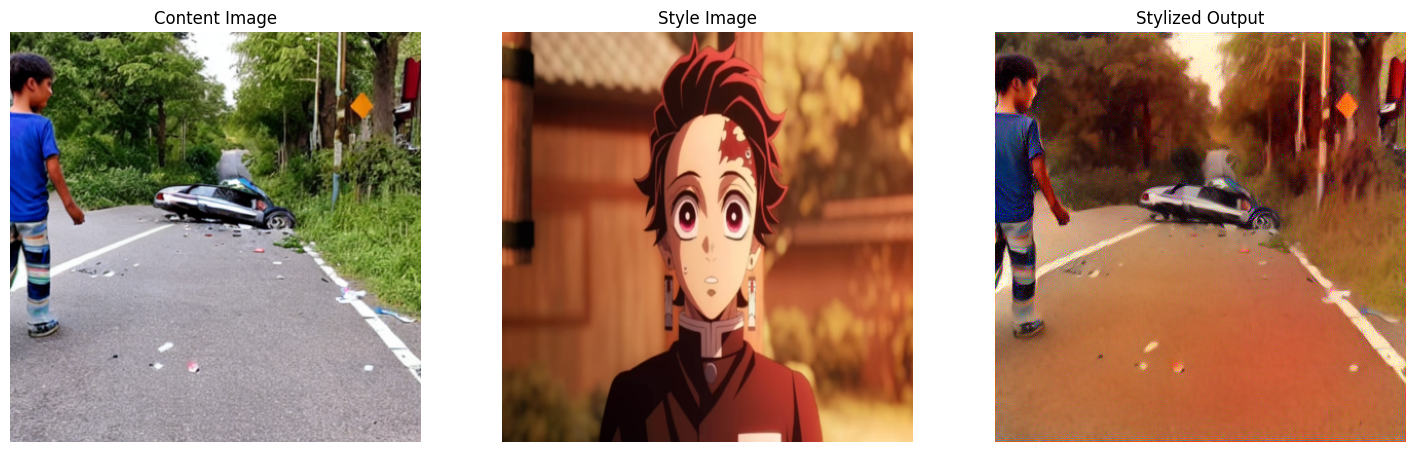

In [ ]:
def im_convert(tensor):
    img = tensor.cpu().clone().detach().squeeze()
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.clamp(0,1)
    return transforms.ToPILImage()(img)

output = im_convert(target)
output.save("/content/drive/MyDrive/new_images/output_LBFGS_like_first.png")

content_disp = im_convert(content_img)
style_disp   = im_convert(style_img)
output_disp  = output

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(content_disp)
plt.title("Content Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(style_disp)
plt.title("Style Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(output_disp)
plt.title("Stylized Output")
plt.axis("off")

plt.show()
